<a href="https://colab.research.google.com/github/woozins/volatility_prediction/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/volatility')

### BaseModel fitting
### 1. RiskMetrix
### 2. Garch model

### vs : Deep Learning model : transformer - based:
### 1. transformer
### 2. temporal fusion transformer
### 3. informer
### 4. temporal convolutional network
### 5. wavenet
### 6. N-Beats
### 7. DeepAR : 이 중 공변량 처리가 가능한 모델?

In [ ]:
pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 kB 17.6 MB/s eta 0:00:00


In [ ]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime


In [ ]:
## Getting KOSPI INDEX DATA:

# 코스피 지수 데이터 가져오기
kospi_data = stock.get_index_ohlcv_by_date("20100101", "20241031", "1001")  # 1001은 코스피의 ID
kospi_price_data = pd.DataFrame(kospi_data['종가'])
# 날짜가 다른 문제 발생

In [ ]:
rtrn = [1]+[kospi_price_data.종가[i] / kospi_price_data.종가[i-1] for i in range(1,3656)]
kospi_price_data['rtrn'] = rtrn
kospi_price_data['log_return'] = np.log(rtrn)
kospi_price_data['volatility'] = (kospi_price_data.log_return)**2
kospi_price_data

<ipython-input-6-0b5bd42f8c33>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rtrn = [1]+[kospi_price_data.종가[i] / kospi_price_data.종가[i-1] for i in range(1,3656)]


,종가,rtrn,log_return,volatility
날짜,,,,
2010-01-04,1696.14,1.000000,0.000000,0.000000e+00
2010-01-05,1690.62,0.996746,-0.003260,1.062601e-05
2010-01-06,1705.32,1.008695,0.008657,7.495146e-05
2010-01-07,1683.45,0.987175,-0.012908,1.666040e-04
2010-01-08,1695.26,1.007015,0.006991,4.887216e-05
...,...,...,...,...
2024-10-25,2583.27,1.000868,0.000867,7.525462e-07
2024-10-28,2612.43,1.011288,0.011225,1.259958e-04
2024-10-29,2617.80,1.002056,0.002053,4.216647e-06


### Base Models:

#### 1. RiskMetrix Model

In [ ]:
#1. Risk Metrix
# RiskMetrics 변동성 계산 (EWMA)

alpha = 0.94

riskmetrix = [kospi_price_data.volatility[0]]
for i in range(kospi_price_data.shape[0]):
  riskmetrix.append(alpha * kospi_price_data.volatility[i] + (1-alpha)*riskmetrix[i])


kospi_price_data.riskmetrix = riskmetrix[:-1]

<ipython-input-7-faee48928d03>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  riskmetrix = [kospi_price_data.volatility[0]]
<ipython-input-7-faee48928d03>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  riskmetrix.append(alpha * kospi_price_data.volatility[i] + (1-alpha)*riskmetrix[i])
<ipython-input-7-faee48928d03>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  kospi_price_data.riskmetrix = riskmetrix[:-1]


In [ ]:
kospi_price_data.index[3450:3640]

DatetimeIndex(['2023-12-26', '2023-12-27', '2023-12-28', '2024-01-02',
               '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2024-09-23', '2024-09-24', '2024-09-25', '2024-09-26',
               '2024-09-27', '2024-09-30', '2024-10-02', '2024-10-04',
               '2024-10-07', '2024-10-08'],
              dtype='datetime64[ns]', name='날짜', length=190, freq=None)

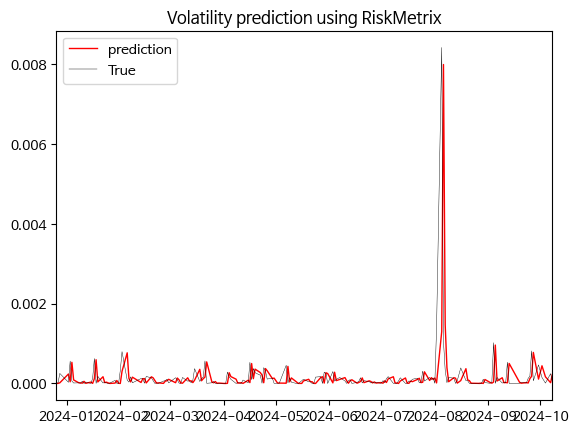

In [ ]:
plt.figure()
plt.plot(kospi_price_data.index, kospi_price_data.riskmetrix, color = 'red', linewidth = 1, label = 'prediction')
plt.plot(kospi_price_data.index, kospi_price_data.volatility, color = 'black', linewidth = 0.3, label = 'True')
plt.title('Volatility prediction using RiskMetrix')
start_date = datetime(2023, 12, 26)
end_date = datetime(2024, 10, 8)
plt.xlim(start_date, end_date)
plt.legend()

In [ ]:
#평가
mean_squared_error(kospi_price_data.volatility, kospi_price_data.riskmetrix)

1.2527542193519675e-07

#### 2. Garch Model2

##### 2.1 Garch(1,1)
##### 2.2 Garch(p,q)


In [ ]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.3 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
# Garch(1,1)
garch_model = arch_model(kospi_price_data.log_return, vol='Garch', p=1, q=1, dist='normal')

# 모델 피팅
fitted_model = garch_model.fit(disp='off')  # disp='off'는 출력을 최소화
fitted_volatility = fitted_model.conditional_volatility

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
kospi_price_data['riskmetrix'] = riskmetrix[:-1]
kospi_price_data['garch_11'] = np.array(fitted_volatility)**2

Text(0.5, 1.0, 'Volatility prediction using Garch(1,1)')

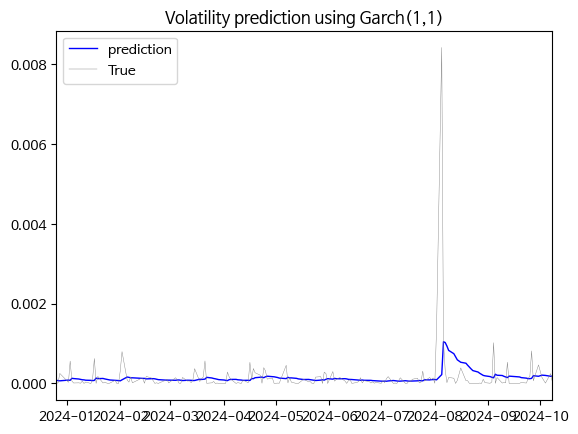

In [ ]:
plt.figure()
plt.plot(kospi_price_data.index, kospi_price_data.garch_11, color = 'blue', linewidth = 1, label = 'prediction')
plt.plot(kospi_price_data.index, kospi_price_data.volatility, color = 'gray', linewidth = 0.3, label = 'True')
plt.legend()
start_date = datetime(2023, 12, 26)
end_date = datetime(2024, 10, 8)
plt.xlim(start_date, end_date)
plt.title('Volatility prediction using Garch(1,1)')

In [ ]:
#평가
print(mean_squared_error(kospi_price_data.volatility, kospi_price_data.riskmetrix))
print(mean_squared_error(kospi_price_data.volatility, kospi_price_data.garch_11))

1.2527542193519675e-07
9.342869850321404e-08


In [ ]:
# Garch(2,3)
garch_model = arch_model(kospi_price_data.log_return, vol='Garch', p=2, q=3, dist='normal')

# 모델 피팅
fitted_model = garch_model.fit(disp='off')  # disp='off'는 출력을 최소화
fitted_volatility = fitted_model.conditional_volatility

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
kospi_price_data['garch_23'] = np.array(fitted_volatility)**2

In [ ]:
#평가
print(mean_squared_error(kospi_price_data.volatility, kospi_price_data.riskmetrix))
print(mean_squared_error(kospi_price_data.volatility, kospi_price_data.garch_23))

1.2527542193519675e-07
9.20735030118402e-08


#### DeepLearning Model : Informer

### Getting appropriate Datasets

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 36.2 MB/s eta 0:00:00


In [ ]:
pip install pytorch_forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
pip install keybert

In [ ]:
!pip install --upgrade tensorflow


In [ ]:
# Uninstall and reinstall TensorFlow and related packages:
!pip uninstall -y tensorflow
!pip uninstall -y transformers
!pip install transformers
!pip install tensorflow

In [ ]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from datetime import datetime
from keybert import KeyBERT
from transformers import BertModel


In [ ]:
model = BertModel.from_pretrained('skt/kobert-base-v1')
kw_model = KeyBERT(model)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
with open('./training_data/2010-01-04.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# 키워드 추출
keywords = kw_model.extract_keywords(text,
                                     top_n = 10,
                                     keyphrase_ngram_range=(1, 2),
                                     stop_words = None)

# 키워드 임베딩
# embeddings = embed_keywords(keywords/)

#### 뉴스 데이터를 감성분석 목적으로 사용

In [ ]:
# Finbert(KB-albert)를 이용해 감성분석 -> 시계열 데이터와 결합하여 예측.

In [ ]:
from transformers import pipeline

# 파이프라인 로드
sentiment_pipeline = pipeline("sentiment-analysis", model="사용할_모델_이름")

# 텍스트 분석
result = sentiment_pipeline(["이 영화 최고에요!", "음식이 정말 별로였어요."])
print(result)  # [{'label': 'POSITIVE', 'score': 0.99}, {'label': 'NEGATIVE', 'score': 0.98}]


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")
model = AutoModelForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC")

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/143k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/294k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/406M [00:00<?, ?B/s]

In [ ]:
# 감성분석 코드

def sentiment_analysis(path):
  with open(path, 'r', encoding='utf-8') as file:
      texts = file.read().split('\n')
      encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

      # 감성 분석 예측
      model.eval()  # 평가 모드
      with torch.no_grad():
          # predictions = torch.empty(size)
          outputs = model(**encodings)
          logits = outputs.logits
          predictions = torch.argmax(logits, dim=-1).float()
          result = torch.mean(torch.abs(predictions - 1))

      return result

In [ ]:
from tqdm import tqdm

In [ ]:
# 감성데이터 추출

data_paths = os.listdir('./training_data')
data_paths.sort()
sentiment = torch.empty(len(data_paths))

for i in tqdm(range(len(data_paths))):
  sentiment[i] = sentiment_analysis('./training_data/' + data_paths[i])

 97%|█████████▋| 3540/3655 [2:59:31<34:41, 18.10s/it]

### Get saved sentiment data

In [ ]:
import torch

In [ ]:
sentiment = torch.load('sentiment.pt')
kospi_price_data = kospi_price_data.drop(['2022-10-24'])
kospi_price_data['sentiment'] = sentiment

<ipython-input-37-f41bb715ac5d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sentiment = torch.load('sentiment.pt')


In [ ]:
kospi_price_data['sentiment_shifted'] = kospi_price_data.sentiment.shift(-1)

In [ ]:
kospi_price_data = kospi_price_data.reset_index()

In [ ]:
kospi_price_data.to_csv('data.csv')

### Fit informer model